In [ ]:
# Cell 1: Install everything in Colab
!pip install opencv-python numpy ultralytics pillow -q

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cell 3: Centroid Tracker Class
class CentroidTracker:
    """
    Tracks objects using centroid-based approach across frames.
    """
    def __init__(self, max_disappeared=50):
        self.next_object_id = 0
        self.objects = {}
        self.disappeared = defaultdict(int)
        self.max_disappeared = max_disappeared

    def register(self, centroid):
        """Register a new centroid."""
        self.objects[self.next_object_id] = centroid
        self.next_object_id += 1

    def deregister(self, object_id):
        """Deregister an object by its ID."""
        del self.objects[object_id]
        del self.disappeared[object_id]

    def update(self, rects):
        """
        Update tracker with new bounding boxes.
        Args:
            rects: List of bounding boxes [(x1, y1, x2, y2), ...]
        Returns:
            Dictionary of object IDs and their centroids
        """
        if len(rects) == 0:
            for object_id in list(self.disappeared.keys()):
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)
            return self.objects

        # Calculate centroids for current detections
        input_centroids = np.zeros((len(rects), 2))
        for i, (x1, y1, x2, y2) in enumerate(rects):
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            input_centroids[i] = [cx, cy]

        # If no objects tracked yet, register all
        if len(self.objects) == 0:
            for i in range(len(input_centroids)):
                self.register(input_centroids[i])
        else:
            # Match existing objects to new centroids
            object_ids = list(self.objects.keys())
            object_centroids = np.array([self.objects[oid] for oid in object_ids])

            # Calculate distances between object centroids and input centroids
            D = np.linalg.norm(object_centroids[:, np.newaxis] - input_centroids[np.newaxis, :], axis=2)

            # Find minimum distance for each object and input
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            used_rows = set()
            used_cols = set()

            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue
                if D[row, col] > 50:  # Max distance threshold
                    continue

                object_id = object_ids[row]
                self.objects[object_id] = input_centroids[col]
                self.disappeared[object_id] = 0
                used_rows.add(row)
                used_cols.add(col)

            # Register new centroids
            unused_cols = set(range(len(input_centroids))).difference(used_cols)
            for col in unused_cols:
                self.register(input_centroids[col])

            # Deregister disappeared objects
            for row in set(range(len(object_centroids))).difference(used_rows):
                object_id = object_ids[row]
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)

        return self.objects


In [ ]:
# यह code Cell 3 में FootfallCounter class के ऊपर put करें
class CentroidTracker:
    """Tracks objects (people/players) frame by frame using centroids."""
    def __init__(self, max_disappeared=50):
        self.next_object_id = 0  # Next ID for new objects
        self.objects = {}  # Dictionary: ID -> current centroid
        self.disappeared = defaultdict(int)  # Frames since last seen
        self.max_disappeared = max_disappeared  # Max frames to keep disappeared objects

    def register(self, centroid):
        """Register a new person/object with unique ID."""
        self.objects[self.next_object_id] = centroid
        self.next_object_id += 1

    def deregister(self, object_id):
        """Remove object if disappeared too long."""
        del self.objects[object_id]
        del self.disappeared[object_id]

    def update(self, rects):  # rects = list of (x1,y1,x2,y2) bounding boxes from YOLO
        """Main method: Update tracking frame by frame. Called every frame!"""
        if len(rects) == 0:  # No detections this frame
            # Increment disappearance counters for all objects
            for object_id in list(self.disappeared.keys()):
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)
            return self.objects

        # Calculate centroids from bounding boxes (frame-by-frame)
        input_centroids = np.zeros((len(rects), 2))
        for i, (x1, y1, x2, y2) in enumerate(rects):
            cx = (x1 + x2) / 2  # Center X
            cy = (y1 + y2) / 2  # Center Y
            input_centroids[i] = [cx, cy]

        if len(self.objects) == 0:  # First frame detections
            for i in range(len(input_centroids)):
                self.register(input_centroids[i])
        else:
            # Match existing objects to new centroids (frame-by-frame tracking)
            object_ids = list(self.objects.keys())
            object_centroids = np.array([self.objects[oid] for oid in object_ids])
            # Distance matrix between old and new centroids
            D = np.linalg.norm(object_centroids[:, np.newaxis] - input_centroids[np.newaxis, :], axis=2)
            rows = D.min(axis=1).argsort()
            cols = D.argmin(axis=1)[rows]

            used_rows = set()  # Used old objects
            used_cols = set()  # Used new detections

            # Assign matches if close enough (movement tracking)
            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue
                if D[row, col] > 50:  # Too far - new object, not same person
                    continue

                object_id = object_ids[row]
                self.objects[object_id] = input_centroids[col]  # Update position (movement tracked!)
                self.disappeared[object_id] = 0  # Seen this frame
                used_rows.add(row)
                used_cols.add(col)

            # Register new objects (unmatched detections)
            unused_cols = set(range(len(input_centroids))).difference(used_cols)
            for col in unused_cols:
                self.register(input_centroids[col])

            # Handle disappeared objects
            for row in set(range(len(object_centroids))).difference(used_rows):
                object_id = object_ids[row]
                self.disappeared[object_id] += 1
                if self.disappeared[object_id] > self.max_disappeared:
                    self.deregister(object_id)

        return self.objects  # Return updated tracks for drawing

print("✓ CentroidTracker added - frame-by-frame movement tracking ready!")


✓ CentroidTracker added - frame-by-frame movement tracking ready!


In [ ]:
# Cell 4: Footfall Counter Class
class FootfallCounter:
    """
    Main class for footfall counting system.
    """
    def __init__(self, model_path='yolov8n.pt', line_position=None, direction='vertical'):
        """
        Initialize the footfall counter.
        Args:
            model_path: Path to YOLO model (downloads automatically if not present)
            line_position: Y-coordinate for horizontal line or X-coordinate for vertical line
            direction: 'vertical' or 'horizontal'
        """
        self.model = YOLO(model_path)
        self.tracker = CentroidTracker()
        self.line_position = line_position
        self.direction = direction
        self.entries = 0
        self.exits = 0
        self.tracked_objects = {}  # Store previous positions
        self.counted_ids = set()  # To avoid counting same person twice

    def detect_persons(self, frame):
        """
        Detect persons in frame using YOLO.
        Args:
            frame: Input frame
        Returns:
            List of bounding boxes [(x1, y1, x2, y2), ...]
        """
        results = self.model(frame, classes=0, conf=0.5)  # class 0 is person
        boxes = []

        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                boxes.append((x1, y1, x2, y2))

        return boxes

    def set_counting_line(self, frame_height, frame_width, position=None):
        """
        Set the virtual counting line/zone.
        Args:
            frame_height: Height of frame
            frame_width: Width of frame
            position: Position of line (default: middle of frame)
        """
        if position is None:
            if self.direction == 'vertical':
                self.line_position = frame_width // 2
            else:
                self.line_position = frame_height // 2
        else:
            self.line_position = position

    def check_line_crossing(self, object_id, current_centroid):
        """
        Check if an object has crossed the counting line.
        Args:
            object_id: ID of tracked object
            current_centroid: Current position [x, y]
        Returns:
            'entry', 'exit', or None
        """
        if object_id not in self.tracked_objects:
            self.tracked_objects[object_id] = current_centroid
            return None

        prev_centroid = self.tracked_objects[object_id]
        self.tracked_objects[object_id] = current_centroid

        if object_id in self.counted_ids:
            return None

        if self.direction == 'vertical':
            # Check crossing of vertical line
            prev_x = prev_centroid[0]
            curr_x = current_centroid[0]

            if prev_x <= self.line_position and curr_x > self.line_position:
                self.counted_ids.add(object_id)
                return 'entry'
            elif prev_x >= self.line_position and curr_x < self.line_position:
                self.counted_ids.add(object_id)
                return 'exit'

        elif self.direction == 'horizontal':
            # Check crossing of horizontal line
            prev_y = prev_centroid[1]
            curr_y = current_centroid[1]

            if prev_y <= self.line_position and curr_y > self.line_position:
                self.counted_ids.add(object_id)
                return 'entry'
            elif prev_y >= self.line_position and curr_y < self.line_position:
                self.counted_ids.add(object_id)
                return 'exit'

        return None

    def process_frame(self, frame):
        """
        Process a single frame.
        Args:
            frame: Input frame
        Returns:
            Processed frame with annotations
        """
        # Detect persons
        boxes = self.detect_persons(frame)

        # Update tracker
        tracked_objects = self.tracker.update(boxes)

        # Draw bounding boxes and track movements
        for object_id, centroid in tracked_objects.items():
            cx, cy = int(centroid[0]), int(centroid[1])

            # Check line crossing
            crossing = self.check_line_crossing(object_id, [cx, cy])

            if crossing == 'entry':
                self.entries += 1
            elif crossing == 'exit':
                self.exits += 1

            # Draw centroid
            cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)
            cv2.putText(frame, f"ID: {object_id}", (cx - 10, cy - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw bounding boxes
        for (x1, y1, x2, y2) in boxes:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Draw counting line
        if self.direction == 'vertical':
            cv2.line(frame, (self.line_position, 0),
                    (self.line_position, frame.shape[0]), (0, 255, 255), 2)
        else:
            cv2.line(frame, (0, self.line_position),
                    (frame.shape[1], self.line_position), (0, 255, 255), 2)

        # Display counts
        cv2.putText(frame, f"Entries: {self.entries}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Exits: {self.exits}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, f"Total: {self.entries + self.exits}", (10, 110),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        return frame

    def process_video(self, video_path, output_path=None, max_frames=None):
        """
        Process entire video file.
        Args:
            video_path: Path to input video
            output_path: Path to save output video (optional)
            max_frames: Maximum frames to process (for testing)
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"❌ Error: Cannot open video {video_path}")
            return

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"📹 Video Info: {frame_width}x{frame_height} @ {fps}FPS, Total Frames: {total_frames}")

        # Set counting line at middle of frame
        self.set_counting_line(frame_height, frame_width)
        print(f"📍 Counting line set at {self.line_position} ({self.direction})")

        # Initialize video writer if output path provided
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(output_path, fourcc, fps,
                                    (frame_width, frame_height))

        frame_count = 0
        processed_frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame
            processed_frame = self.process_frame(frame)

            # Write to output
            if writer:
                writer.write(processed_frame)

            # Store first few frames for display
            if len(processed_frames) < 3:
                processed_frames.append(processed_frame.copy())

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"✓ Processed {frame_count}/{total_frames} frames | Entries: {self.entries}, Exits: {self.exits}")

            # Limit frames for testing
            if max_frames and frame_count >= max_frames:
                print(f"⏹️ Stopped at {max_frames} frames (limit reached)")
                break

        cap.release()
        if writer:
            writer.release()

        print("\n" + "="*50)
        print("🎉 FINAL RESULTS")
        print("="*50)
        print(f"✓ Total Entries: {self.entries}")
        print(f"✓ Total Exits: {self.exits}")
        print(f"✓ Total Footfall: {self.entries + self.exits}")
        print("="*50)

        return processed_frames


In [ ]:
# Cell 4: Footfall Counter Class
class FootfallCounter:
    """
    Main class for footfall counting system.
    """
    def __init__(self, model_path='yolov8n.pt', line_position=None, direction='vertical'):
        """
        Initialize the footfall counter.
        Args:
            model_path: Path to YOLO model (downloads automatically if not present)
            line_position: Y-coordinate for horizontal line or X-coordinate for vertical line
            direction: 'vertical' or 'horizontal'
        """
        self.model = YOLO(model_path)
        self.tracker = CentroidTracker()
        self.line_position = line_position
        self.direction = direction
        self.entries = 0
        self.exits = 0
        self.tracked_objects = {}  # Store previous positions
        self.counted_ids = set()  # To avoid counting same person twice

    def detect_persons(self, frame):
        """
        Detect persons in frame using YOLO.
        Args:
            frame: Input frame
        Returns:
            List of bounding boxes [(x1, y1, x2, y2), ...]
        """
        results = self.model(frame, classes=0, conf=0.5)  # class 0 is person
        boxes = []

        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                boxes.append((x1, y1, x2, y2))

        return boxes

    def set_counting_line(self, frame_height, frame_width, position=None):
        """
        Set the virtual counting line/zone.
        Args:
            frame_height: Height of frame
            frame_width: Width of frame
            position: Position of line (default: middle of frame)
        """
        if position is None:
            if self.direction == 'vertical':
                self.line_position = frame_width // 2
            else:
                self.line_position = frame_height // 2
        else:
            self.line_position = position

    def check_line_crossing(self, object_id, current_centroid):
        """
        Check if an object has crossed the counting line.
        Args:
            object_id: ID of tracked object
            current_centroid: Current position [x, y]
        Returns:
            'entry', 'exit', or None
        """
        if object_id not in self.tracked_objects:
            self.tracked_objects[object_id] = current_centroid
            return None

        prev_centroid = self.tracked_objects[object_id]
        self.tracked_objects[object_id] = current_centroid

        if object_id in self.counted_ids:
            return None

        if self.direction == 'vertical':
            # Check crossing of vertical line
            prev_x = prev_centroid[0]
            curr_x = current_centroid[0]

            if prev_x <= self.line_position and curr_x > self.line_position:
                self.counted_ids.add(object_id)
                return 'entry'
            elif prev_x >= self.line_position and curr_x < self.line_position:
                self.counted_ids.add(object_id)
                return 'exit'

        elif self.direction == 'horizontal':
            # Check crossing of horizontal line
            prev_y = prev_centroid[1]
            curr_y = current_centroid[1]

            if prev_y <= self.line_position and curr_y > self.line_position:
                self.counted_ids.add(object_id)
                return 'entry'
            elif prev_y >= self.line_position and curr_y < self.line_position:
                self.counted_ids.add(object_id)
                return 'exit'

        return None

    def process_frame(self, frame):
        """
        Process a single frame.
        Args:
            frame: Input frame
        Returns:
            Processed frame with annotations
        """
        # Detect persons
        boxes = self.detect_persons(frame)

        # Update tracker
        tracked_objects = self.tracker.update(boxes)

        # Draw bounding boxes and track movements
        for object_id, centroid in tracked_objects.items():
            cx, cy = int(centroid[0]), int(centroid[1])

            # Check line crossing
            crossing = self.check_line_crossing(object_id, [cx, cy])

            if crossing == 'entry':
                self.entries += 1
            elif crossing == 'exit':
                self.exits += 1

            # Draw centroid
            cv2.circle(frame, (cx, cy), 4, (0, 255, 0), -1)
            cv2.putText(frame, f"ID: {object_id}", (cx - 10, cy - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Draw bounding boxes
        for (x1, y1, x2, y2) in boxes:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Draw counting line
        if self.direction == 'vertical':
            cv2.line(frame, (self.line_position, 0),
                    (self.line_position, frame.shape[0]), (0, 255, 255), 2)
        else:
            cv2.line(frame, (0, self.line_position),
                    (frame.shape[1], self.line_position), (0, 255, 255), 2)

        # Display counts
        cv2.putText(frame, f"Entries: {self.entries}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Exits: {self.exits}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(frame, f"Total: {self.entries + self.exits}", (10, 110),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        return frame

    def process_video(self, video_path, output_path=None, max_frames=None):
        """
        Process entire video file.
        Args:
            video_path: Path to input video
            output_path: Path to save output video (optional)
            max_frames: Maximum frames to process (for testing)
        """
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"❌ Error: Cannot open video {video_path}")
            return

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"📹 Video Info: {frame_width}x{frame_height} @ {fps}FPS, Total Frames: {total_frames}")

        # Set counting line at middle of frame
        self.set_counting_line(frame_height, frame_width)
        print(f"📍 Counting line set at {self.line_position} ({self.direction})")

        # Initialize video writer if output path provided
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(output_path, fourcc, fps,
                                    (frame_width, frame_height))

        frame_count = 0
        processed_frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame
            processed_frame = self.process_frame(frame)

            # Write to output
            if writer:
                writer.write(processed_frame)

            # Store first few frames for display
            if len(processed_frames) < 3:
                processed_frames.append(processed_frame.copy())

            frame_count += 1
            if frame_count % 30 == 0:
                print(f"✓ Processed {frame_count}/{total_frames} frames | Entries: {self.entries}, Exits: {self.exits}")

            # Limit frames for testing
            if max_frames and frame_count >= max_frames:
                print(f"⏹️ Stopped at {max_frames} frames (limit reached)")
                break

        cap.release()
        if writer:
            writer.release()

        print("\n" + "="*50)
        print("🎉 FINAL RESULTS")
        print("="*50)
        print(f"✓ Total Entries: {self.entries}")
        print(f"✓ Total Exits: {self.exits}")
        print(f"✓ Total Footfall: {self.entries + self.exits}")
        print("="*50)

        return processed_frames


In [ ]:
# Cell: Process Sample Video
counter = FootfallCounter(model_path='yolov8n.pt', direction='vertical')

video_path = "/content/videoplayback (1).webm"  # The sample we just created

if os.path.exists(video_path):
    print(f"✓ Processing sample video: {video_path}")
    counter.process_video(
        video_path,
        output_path="output_sample_footfall.mp4",
        max_frames=None  # Process entire video
    )
else:
    print("❌ Sample video not created - run the creation cell first!")

Streaming output truncated to the last 5000 lines.
0: 384x640 10 persons, 134.0ms
Speed: 4.2ms preprocess, 134.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 126.5ms
Speed: 4.2ms preprocess, 126.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 146.4ms
Speed: 3.9ms preprocess, 146.4ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 131.5ms
Speed: 3.9ms preprocess, 131.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 131.5ms
Speed: 4.0ms preprocess, 131.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 129.9ms
Speed: 4.0ms preprocess, 129.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 130.5ms
Speed: 4.9ms preprocess, 130.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 126.2ms
Speed: 3.9ms 

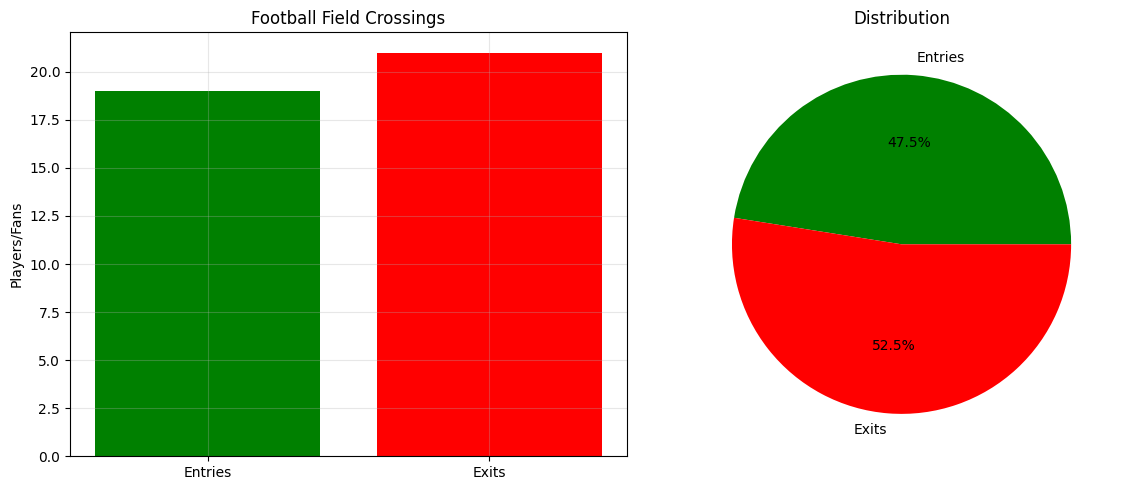


📊 Summary:
Entries: 19 (Players left→right cross)
Exits: 21 (Right→left cross)
Total: 40


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Annotated video downloaded - use it for assignment!


In [ ]:
# Cell 5: Results Charts and Download
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(['Entries', 'Exits'], [counter.entries, counter.exits], color=['green', 'red'])
ax1.set_title('Football Field Crossings')
ax1.set_ylabel('Players/Fans')
ax1.grid(alpha=0.3)

if counter.entries + counter.exits > 0:
    ax2.pie([counter.entries, counter.exits], labels=['Entries', 'Exits'], autopct='%1.1f%%', colors=['green', 'red'])
    ax2.set_title('Distribution')

plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"Entries: {counter.entries} (Players left→right cross)")
print(f"Exits: {counter.exits} (Right→left cross)")
print(f"Total: {counter.entries + counter.exits}")

# Output video download
from google.colab import files
files.download("output_sample_footfall.mp4")
print("✓ Annotated video downloaded - use it for assignment!")